# import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings 
warnings.filterwarnings("ignore")
import time

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensor2tensor as tt

# DATA PREPARATION
## Load the training data and test data

In [3]:
column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
               's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_FD004 = pd.read_table("./CMAPSSData/train_FD004.txt", header=None, delim_whitespace=True)
train_FD004.columns = column_name
# Test 文件中的cycle数 并不是到死的
test_FD004 = pd.read_table("./CMAPSSData/test_FD004.txt", header=None, delim_whitespace=True)
test_FD004.columns = column_name

# load RUL data 真正的最后循环数存放在这里
RUL_FD004 = pd.read_table("./CMAPSSData/RUL_FD004.txt", header=None, delim_whitespace=True)

In [4]:
train_FD004.describe()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,...,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000
mean,124.325181,134.311417,23.999823,0.571347,94.031576,472.882435,579.420056,1417.896600,1201.915359,8.031626,...,266.735665,2334.427590,8067.811812,9.285604,0.023252,347.760029,2228.613283,97.751396,20.864333,12.518995
std,71.995350,89.783389,14.780722,0.310703,14.251954,26.436832,37.342647,106.167598,119.327591,3.622872,...,138.479109,128.197859,85.670543,0.750374,0.004685,27.808283,145.472491,5.369424,9.936396,5.962697
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.480000,1242.670000,1024.420000,3.910000,...,128.310000,2027.570000,7845.780000,8.175700,0.020000,302.000000,1915.000000,84.930000,10.160000,6.084300
25%,60.000000,62.000000,10.004600,0.250700,100.000000,445.000000,549.330000,1350.550000,1119.490000,3.910000,...,134.520000,2387.910000,8062.630000,8.648000,0.020000,330.000000,2212.000000,100.000000,10.940000,6.566100
50%,126.000000,123.000000,25.001400,0.700000,100.000000,462.540000,555.740000,1367.680000,1136.920000,7.050000,...,183.450000,2388.060000,8083.810000,9.255600,0.020000,334.000000,2223.000000,100.000000,14.930000,8.960100
75%,185.000000,191.000000,41.998100,0.840000,100.000000,491.190000,607.070000,1497.420000,1302.620000,10.520000,...,371.400000,2388.170000,8128.350000,9.365800,0.030000,368.000000,2324.000000,100.000000,28.560000,17.135500
max,249.000000,543.000000,42.008000,0.842000,100.000000,518.670000,644.420000,1613.000000,1440.770000,14.620000,...,537.490000,2390.490000,8261.650000,11.066300,0.030000,399.000000,2388.000000,100.000000,39.890000,23.885200


# Feature extention

## Difference with previous row

In [5]:
train_FD004 = train_FD004.drop(['setting1','setting2','setting3'],axis = 1)

In [6]:
test_FD004 = test_FD004.drop(['setting1','setting2','setting3'],axis = 1)

In [7]:
# _id =1
# s2_diff = []
# s2_diff_temp = []
# diff_periods = 40
# for _id in set(train_FD004[id]):
#     trainFD004_of_one_id =  train_FD004[train_FD004[id] == _id]
#     s2 = pd.Series(trainFD004_of_one_id['s2'])
#     for i in range(diff_periods):
#         s2_diff.append(s2.iloc[i]-s2.iloc[0])
#     s2_diff_temp=s2.diff(periods=diff_periods)
#     for j in range (len(s2)-diff_periods):
#         s2_diff.append(s2_diff_temp.iloc[diff_periods])


In [8]:
def cal_diff(df, sensor_name,diff_periods = 40):
    _id =1
    sensor_diff = []
    sensor_diff_temp = []
    for _id in set(df['engine_id']):
        trainFD004_of_one_id =  df[df['engine_id'] == _id]
        s = pd.Series(trainFD004_of_one_id[sensor_name])
        #判断每一个数列的长度是否大于diff_periods
        if len(s)>diff_periods:
            sensor_diff_temp=s.diff(periods=diff_periods)
            # 第0到39 应该是每一个值-第一个值
            for i in range(diff_periods):
                sensor_diff.append(s.iloc[i]-s.iloc[0])
            # 第40个值之后应该是每一个值-向前推40位的值
            for j in range (len(s)-diff_periods):
                sensor_diff.append(sensor_diff_temp.iloc[diff_periods+j])
        else:
            for h in range(len(s)):
                sensor_diff.append(s.iloc[h]-s.iloc[0])
    return sensor_diff

In [9]:
#from Feature_extention import cal_diff

In [10]:
#get all the names of sensors
list(train_FD004.columns)
sensor_name = list(train_FD004.columns)
sensor_name = sensor_name[2:]
sensor_name

['s1',
 's2',
 's3',
 's4',
 's5',
 's6',
 's7',
 's8',
 's9',
 's10',
 's11',
 's12',
 's13',
 's14',
 's15',
 's16',
 's17',
 's18',
 's19',
 's20',
 's21']

In [11]:
for i in range(len(sensor_name)):
    sensor_name_temp = sensor_name[i]
    diff = cal_diff(train_FD004,sensor_name=sensor_name_temp) 
    name = sensor_name_temp+'_diff'
    train_FD004[name] = diff

In [12]:
for i in range(len(sensor_name)):
    sensor_name_temp = sensor_name[i]
    diff = cal_diff(test_FD004,sensor_name=sensor_name_temp) 
    name = sensor_name_temp+'_diff'
    test_FD004[name] = diff

In [13]:
test_FD004

,engine_id,cycle,s1,s2,s3,s4,s5,s6,s7,s8,...,s12_diff,s13_diff,s14_diff,s15_diff,s16_diff,s17_diff,s18_diff,s19_diff,s20_diff,s21_diff
0,1,1,491.19,606.67,1481.04,1227.81,9.35,13.60,332.52,2323.67,...,0.00,0.00,0.00,0.0000,0.00,0.0,0.0,0.00,0.00,0.0000
1,1,2,462.54,536.22,1256.17,1031.48,7.05,9.00,174.46,1915.21,...,-149.42,-359.69,-185.52,1.6403,0.00,-56.0,-409.0,-15.07,-9.95,-6.1259
2,1,3,445.00,549.23,1340.13,1105.88,3.91,5.69,137.34,2211.93,...,-183.05,0.17,22.15,0.1731,0.00,-34.0,-112.0,0.00,-13.92,-8.2642
3,1,4,445.00,549.19,1339.70,1107.26,3.91,5.69,137.23,2211.89,...,-183.55,0.12,29.91,0.1365,0.00,-34.0,-112.0,0.00,-13.75,-8.4640
4,1,5,449.44,555.10,1353.04,1117.80,5.48,7.97,192.94,2222.71,...,-131.21,0.09,8.85,0.0801,0.00,-29.0,-101.0,0.00,-9.46,-5.7681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,248,277,445.00,550.30,1364.40,1129.17,3.91,5.72,138.34,2212.35,...,-183.61,0.26,43.99,0.2115,0.00,-36.0,-112.0,0.00,-13.61,-8.4730
41210,248,278,491.19,608.00,1494.75,1260.88,9.35,13.66,334.75,2324.23,...,-56.76,0.13,-57.25,0.5827,-0.01,-6.0,5.0,0.00,-4.15,-2.3911
41211,248,279,449.44,555.92,1370.65,1130.97,5.48,8.00,194.92,2223.57,...,52.17,0.49,1.52,0.0000,0.00,5.0,11.0,0.00,4.06,2.4742
41212,248,280,491.19,608.19,1489.11,1256.25,9.35,13.66,333.15,2324.19,...,183.74,0.14,-13.55,-0.0951,0.01,34.0,112.0,0.00,13.93,8.3970


In [14]:
train_FD004.describe()

,engine_id,cycle,s1,s2,s3,s4,s5,s6,s7,s8,...,s12_diff,s13_diff,s14_diff,s15_diff,s16_diff,s17_diff,s18_diff,s19_diff,s20_diff,s21_diff
count,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,...,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000
mean,124.325181,134.311417,472.882435,579.420056,1417.896600,1201.915359,8.031626,11.589457,283.328633,2228.686034,...,1.548875,0.427146,4.262664,-0.005800,0.000204,0.700011,0.928864,0.015501,0.094705,0.057766
std,71.995350,89.783389,26.436832,37.342647,106.167598,119.327591,3.622872,5.444017,146.880210,145.348243,...,196.638733,180.971800,119.002142,1.055703,0.006581,39.300465,205.395977,7.579877,14.120938,8.472765
min,1.000000,1.000000,445.000000,535.480000,1242.670000,1024.420000,3.910000,5.670000,136.170000,1914.720000,...,-404.480000,-360.730000,-309.860000,-2.586100,-0.010000,-91.000000,-473.000000,-15.070000,-29.020000,-17.338300
25%,60.000000,62.000000,445.000000,549.330000,1350.550000,1119.490000,3.910000,5.720000,142.920000,2211.950000,...,-150.120000,-0.070000,-46.700000,-0.683900,0.000000,-28.000000,-107.000000,0.000000,-10.250000,-6.149300
50%,126.000000,123.000000,462.540000,555.740000,1367.680000,1136.920000,7.050000,9.030000,194.960000,2223.070000,...,0.100000,0.040000,2.740000,-0.001700,0.000000,0.000000,0.000000,0.000000,0.010000,0.003600
75%,185.000000,191.000000,491.190000,607.070000,1497.420000,1302.620000,10.520000,15.480000,394.280000,2323.930000,...,150.480000,0.190000,54.120000,0.679900,0.000000,30.000000,107.000000,0.000000,10.290000,6.174100
max,249.000000,543.000000,518.670000,644.420000,1613.000000,1440.770000,14.620000,21.610000,570.810000,2388.640000,...,404.650000,360.970000,341.340000,2.591000,0.010000,92.000000,473.000000,15.070000,29.190000,17.526500


## standard normalization 

In [15]:
#### standard normalization ####

# Training 因为前两列是没有用的 engine_id cycle
mean = train_FD004.iloc[:, 2:].mean()
std = train_FD004.iloc[:, 2:].std()
std.replace(0, 1, inplace=True)
train_FD004.iloc[:, 2:] = (train_FD004.iloc[:, 2:] - mean) / std

# Testing
test_FD004.iloc[:, 2:] = (test_FD004.iloc[:, 2:] - mean) / std

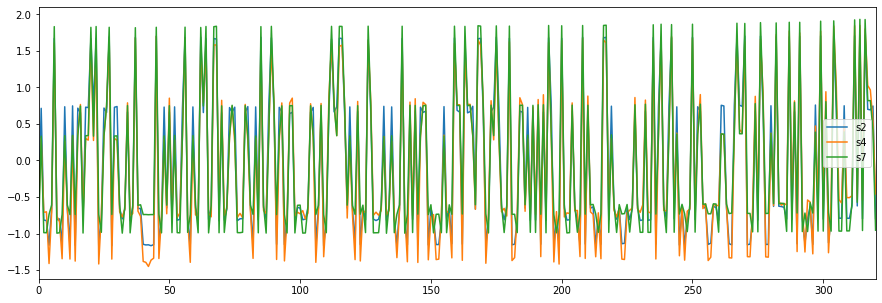

In [16]:
train_FD004[train_FD004["engine_id"]==1][["s2","s4","s7"]].plot(figsize=(15,5));

## Compute the RUL

### Training 

In [17]:
id='engine_id'
# 这个是自己定义的， 拐点在120 ，  120之前视为一样
MAXLIFE =130
rul = [] # 会逐渐装满所有id的RUL
for _id in set(train_FD004[id]):
    trainFD004_of_one_id =  train_FD004[train_FD004[id] == _id]
    cycle_list = trainFD004_of_one_id['cycle'].tolist()
    # 因为这里是run to end ,所以最大cycle数是确定的
    max_cycle = max(cycle_list)
    # 计算出临界点的位置，没到达临界点的时候，全部保存MAXLIFE，到达临界点的时候，逐点下降！
#     if MAXLIFE >= max_cycle:
#         for i in range(0, len(cycle_list)):
#             tmp = max_cycle-i
#             kink_RUL.append(tmp)
#     else:
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        # 
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = max_cycle-i-1
            kink_RUL.append(tmp)
    # 每跑完一个id就添加到最后总的rul列表中
    rul.extend(kink_RUL)
train_FD004["RUL"] = rul


### Testing

In [18]:
id='engine_id'
rul = []
for _id_test in set(test_FD004[id]):
    # 真实的RUL， 也就是测试数据最后一个周期所对应的RUL
    true_rul = int(RUL_FD004.iloc[_id_test - 1])
    testFD004_of_one_id =  test_FD004[test_FD004[id] == _id_test]
    cycle_list = testFD004_of_one_id['cycle'].tolist()
    # 那么总的生命周期数=训练集的已有周期数+最后剩下的周期数
    max_cycle = max(cycle_list) + true_rul
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = max_cycle-i-1
            kink_RUL.append(tmp)    

    rul.extend(kink_RUL)

test_FD004["RUL"] = rul

In [19]:
min_shape = np.min([i[0] for i in train_FD004.groupby("engine_id").apply(np.shape).values])
print("训练集中最小的长度是：",min_shape)

训练集中最小的长度是： 128


In [20]:
min_shape = np.min([i[0] for i in test_FD004.groupby("engine_id").apply(np.shape).values])
print("测试集中最小的长度是：",min_shape)

测试集中最小的长度是： 19


In [21]:
train_FD004[train_FD004["engine_id"]==1].head()

,engine_id,cycle,s1,s2,s3,s4,s5,s6,s7,s8,...,s13_diff,s14_diff,s15_diff,s16_diff,s17_diff,s18_diff,s19_diff,s20_diff,s21_diff,RUL
0,1,1,-1.054681,-0.796410,-0.701406,-0.745723,-1.137668,-1.081822,-0.993794,-0.115764,...,-0.002360,-0.035820,0.005494,-0.030961,-0.017812,-0.004522,-0.002045,-0.006707,-0.006818,130
1,1,2,0.692502,0.713660,0.562445,0.298210,0.363903,0.371149,0.332049,0.653424,...,-0.003797,-0.276992,-0.129203,-0.030961,0.770983,0.540766,-0.002045,0.967025,0.971399,130
2,1,3,-1.054681,-0.815959,-0.704326,-0.711196,-1.137668,-1.083659,-0.988211,-0.115351,...,-0.002471,-0.104810,0.069148,-0.030961,-0.043257,-0.004522,-0.002045,-0.016621,-0.000409,130
3,1,4,-1.054681,-0.822653,-0.722034,-0.702984,-1.137668,-1.081822,-0.989573,-0.115626,...,-0.002195,-0.025568,0.008714,-0.030961,-0.068702,-0.004522,-0.002045,-0.012372,-0.000846,130
4,1,5,-0.391213,-1.160069,-1.532168,-1.410616,-0.270952,-0.475652,-0.738756,-2.156655,...,-1.991123,-1.792343,1.429284,-0.030961,-0.653937,-1.450510,-1.990204,0.234779,0.265632,130


### 去掉不变的sensor的值和setting

In [22]:
train_FD004

,engine_id,cycle,s1,s2,s3,s4,s5,s6,s7,s8,...,s13_diff,s14_diff,s15_diff,s16_diff,s17_diff,s18_diff,s19_diff,s20_diff,s21_diff,RUL
0,1,1,-1.054681,-0.796410,-0.701406,-0.745723,-1.137668,-1.081822,-0.993794,-0.115764,...,-0.002360,-0.035820,0.005494,-0.030961,-0.017812,-0.004522,-0.002045,-0.006707,-0.006818,130
1,1,2,0.692502,0.713660,0.562445,0.298210,0.363903,0.371149,0.332049,0.653424,...,-0.003797,-0.276992,-0.129203,-0.030961,0.770983,0.540766,-0.002045,0.967025,0.971399,130
2,1,3,-1.054681,-0.815959,-0.704326,-0.711196,-1.137668,-1.083659,-0.988211,-0.115351,...,-0.002471,-0.104810,0.069148,-0.030961,-0.043257,-0.004522,-0.002045,-0.016621,-0.000409,130
3,1,4,-1.054681,-0.822653,-0.722034,-0.702984,-1.137668,-1.081822,-0.989573,-0.115626,...,-0.002195,-0.025568,0.008714,-0.030961,-0.068702,-0.004522,-0.002045,-0.012372,-0.000846,130
4,1,5,-0.391213,-1.160069,-1.532168,-1.410616,-0.270952,-0.475652,-0.738756,-2.156655,...,-1.991123,-1.792343,1.429284,-0.030961,-0.653937,-1.450510,-1.990204,0.234779,0.265632,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,0.611555,0.693843,0.927434,0.950029,0.686851,0.710972,0.825580,0.625903,...,0.000292,0.684671,-0.742539,1.488555,1.076323,0.516423,-0.002045,1.306945,1.314711,4
61245,249,252,1.731961,1.713857,1.705072,1.884347,1.818550,1.833305,1.935328,1.099318,...,-0.001310,0.872651,-0.854407,1.488555,0.745538,0.307071,-0.002045,1.029343,1.052506,3
61246,249,253,1.731961,1.720819,1.787960,1.916109,1.818550,1.833305,1.945200,1.099593,...,-0.001145,0.964666,-0.783933,1.488555,0.745538,0.307071,-0.002045,1.064044,1.071791,2
61247,249,254,-0.886734,-0.633326,-0.344800,-0.450318,-0.704310,-0.666687,-0.567800,-0.033754,...,0.000734,0.288712,-0.171261,-0.030961,0.033078,-0.004522,-0.002045,0.024453,-0.015457,1


### plot a figure

training (61249, 42) (61249,)
testing (41214, 42) (41214,)


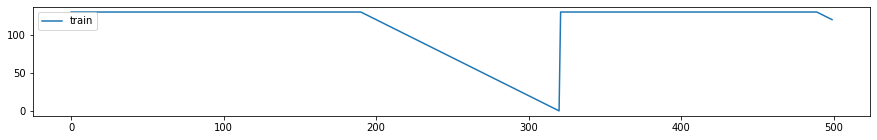

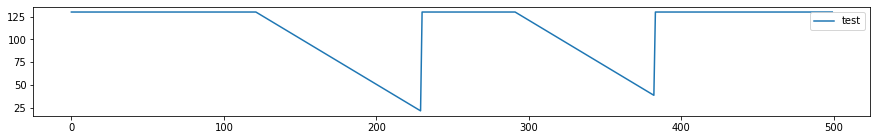

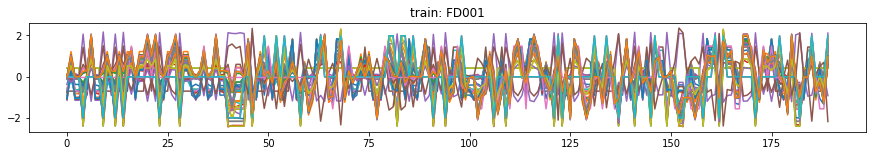

In [23]:
training_data = train_FD004.values
testing_data = test_FD004.values

x_train = training_data[:, 2:-1]
y_train = training_data[:, -1]
print("training", x_train.shape, y_train.shape)

x_test = testing_data[:, 2:-1]
y_test = testing_data[:, -1]
print("testing", x_test.shape, y_test.shape)
# 训练数据集 前面500个数据点所对应的rul 由图中可以看出  都是到零的了
plt.figure(figsize=(15,2))
plt.plot(y_train[:500], label="train")
plt.legend()
plt.figure(figsize=(15,2))
# 测试数据中前500个数据点对应的tul  可以看到结尾数据的rul 都不是中间
plt.plot(y_test[:500], label="test")
plt.legend()
plt.figure(figsize=(15,2))
plt.plot(x_train[:190])
plt.title("train: FD00" + str(1))
# 训练数据第一个id的 24个senor的值 可以通过在x轴坐标100的位置 序列的一些 趋势

plt.show()

In [24]:
def batch_generator(training_data, sequence_length=15, window_size = 15):
    """
    Generator function for creating random batches of training-data for many to many models
    """
    engine_ids = list(training_data["engine_id"].unique())
    temp = training_data.copy()
    # 把 每一段后一截给截掉，获取能够跑的index
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # cutoff_cycle 记录下这以后的index就不满足 序列大小的需求的
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 1
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            drop_range = indexes
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle+2].index
            drop_range = list(range(cutoff_cycle_index[0], indexes[-1] + 1))
            
        temp.drop(drop_range, inplace=True)
    indexes = temp.index
    del temp
    

    x_shape = (len(indexes), sequence_length, window_size, 42)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(indexes))
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    
    # 第一个数据集
    alt_index = indexes[0]
    for batch_index, index in enumerate(indexes):
        # 因为对齐的原因，都减去了1
        y_batch[batch_index] = training_data.iloc[index+window_size-2+sequence_length,-1]
        
        # 本来应该下面这个 for 循环的，但是考虑到循环的嵌套，跑太久了，而且窗口序列之间又有重复，那么减少循环的次数
        # for seq in range(sequence_length):
            # x_batch[index,seq] = training_data.iloc[idx+seq:idx+seq + window_size, 2:-1].values
        
        if index-alt_index==1 and batch_index!=0:
            temp_window = training_data.iloc[index+sequence_length-1:index+sequence_length-1 + window_size, 2:-1].values.reshape(1,window_size,-1)
            x_batch[batch_index] = np.concatenate((x_batch[batch_index-1][1:],temp_window))
        else:
            for seq in range(sequence_length):
                x_batch[batch_index][seq] = training_data.iloc[index+seq:index+seq + window_size, 2:-1].values
        alt_index = index
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

In [25]:
sequence_length=5
window_size = 15
kernel_size = 3

In [26]:
x_batch, y_batch =batch_generator(train_FD004,sequence_length=sequence_length,window_size = window_size)
# 这里需要把输入数据增加一个channel层数
x_batch = np.expand_dims(x_batch, axis=4)
#y_batch = np.expand_dims(y_batch, axis=2)


In [27]:
y_batch.shape

(56767,)

In [28]:
def test_batch_generator(test_data, sequence_length=10, window_size = 10):
    """
    这里的seq 和 win size 必须要和前面training的一致
    """
    engine_ids = list(test_data["engine_id"].unique())
    index_list=[]
    temp = test_data.copy()
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # 找到对应的index，index以前的数据相当于抛弃了，，这个有待改进
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 2
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle].index
            index_list.append(cutoff_cycle_index.values[0])
            

    del temp
    

    x_shape = (len(index_list), sequence_length, window_size, 42)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(index_list))
    y_batch = np.zeros(shape=y_shape)
    


    for test_index, index in enumerate(index_list):
        y_batch[test_index] = test_data.iloc[index+window_size-2+sequence_length,-1]
        
        for seq in range(sequence_length):
            x_batch[test_index][seq] = test_data.iloc[index+seq:index+seq + window_size, 2:-1].values
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

In [29]:
x_batch_test, y_batch_test =  test_batch_generator(test_FD004, sequence_length=sequence_length,window_size = window_size)
x_batch_test = np.expand_dims(x_batch_test, axis=4)

In [30]:
x_batch_test.shape

(248, 5, 15, 42, 1)

In [31]:
y_batch_test.shape

(248,)

In [41]:
from ConvLSTM2D_2 import ConvLSTM2D_2
#from self_attention import self_attention
import tensorflow as tf
from tensorflow.keras import layers



class self_attention(layers.Layer):
    """
    input_shape should be a 5 dimensional tensor
    input_shape = batch_size * timestep * row * feature * channels
    feature should be 1 after the Conv_LSTM
    the input will have to rehape first 
    shape = batch_size * [timestep*row*feature] * channels
    [timestep*row*feature] ist the time feature
    output_shape is 3D tensor
    this layer apply the attention mechanismus on channels with time feature
    
    if key_value = True
        the key and value are the same
        key = value = input
    if key_value = False
        key = input x key_weight
        value = input x value_weight
    query = input x query_weights
    score = dot_product(query, key)
    Calculate softmax(score)
    alignment_vectors = value * score
    output = sum(alignment_vectors of all input)
    output is 3D
    
    """

    def __init__(self, 
                 key_value = False,):
        super(self_attention, self).__init__()
        self.key_value = key_value

        
    def build(self,input_shape):
        self.key_weight = self.add_weight(shape = (input_shape[2], 35),
                                          initializer = 'random_normal',
                                          name = 'key_weight',
                                          trainable=True)
        
        self.value_weight = self.add_weight(shape = (input_shape[2], 35),
                                          name = 'random_normal',
                                            trainable=True)
        
        self.query_weight = self.add_weight(shape = (input_shape[2], 35),
                                          name = 'query_weight',
                                            trainable=True)
        
        
    def call(self, inputs):
        #print(inputs.shape)
        
        
        query = tf.matmul(inputs,self.query_weight)
        #print(query.shape)
        
        value = tf.matmul(inputs,self.value_weight)
        
        key = tf.matmul(inputs,self.key_weight)
        
        key_r = tf.transpose(key,perm=[0, 2, 1])
        #print(key_r.shape)
        
        score = tf.matmul(query,key_r)
        #print(key_r.shape)
        
        score_soft = tf.nn.softmax(score, axis = 2)
        
        score_r = tf.transpose(score_soft,perm=[0, 2, 1])
        
        outputs = value[:,:,None]*score_r[:,:,:,None]
        
        output = tf.keras.backend.sum(outputs,axis=1)
        #print(output.shape)
        
        return output


In [54]:
model =Sequential()
# input 的shape 应该是 （时间，行-window，列-sensor， channels）
# 参数个数怎么算？？？为啥改变filter个数，参数个数不是按比例增长
# 增加batch ？ 增加 dropout??
model.add(ConvLSTM2D_2(filters=10, kernel_size=(kernel_size, 22),cov_kernel_size=(3, 21),input_shape=(None, window_size, 42, 1), padding='valid', return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(ConvLSTM2D_2(filters=20, kernel_size=(kernel_size, 1),cov_kernel_size=(3, 1),padding='valid', return_sequences=True))
model.add(keras.layers.BatchNormalization())
#model.add(ConvLSTM2D_2(filters=20, kernel_size=(kernel_size, 1),cov_kernel_size=(3, 1),padding='valid', return_sequences=True))
#model.add(keras.layers.BatchNormalization())
model.add(tf.compat.v2.keras.layers.Dropout(0.5))
#model.add(Flatten())
model.add(tf.keras.layers.Reshape((35,20)))
model.add(self_attention())
model.add(Flatten())
model.add(Dense(units = 50, activation = "linear"))
model.add(Dense(units = 1, activation = "linear"))
model.compile(loss='mse', optimizer='Adam')

In [55]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2_10 (ConvLSTM2 (None, None, 11, 1, 10)   85780     
_________________________________________________________________
batch_normalization_10 (Batc (None, None, 11, 1, 10)   40        
_________________________________________________________________
conv_lst_m2d_2_11 (ConvLSTM2 (None, None, 7, 1, 20)    18080     
_________________________________________________________________
batch_normalization_11 (Batc (None, None, 7, 1, 20)    80        
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 7, 1, 20)    0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 35, 20)            0         
_________________________________________________________________
self_attention_4 (self_atten (None, 35, 35)           

In [56]:
model.fit(x_batch,y_batch, batch_size=1, epochs=35, validation_split=0.05)

Train on 53928 samples, validate on 2839 samples
Epoch 1/35
 2399/53928 [>.............................] - ETA: 28:59 - loss: 2880.1427

KeyboardInterrupt: 

# Evaluation

## Tranining Performance

In [ ]:
y_batch_pred = model.predict(x_batch)

In [ ]:
y_batch_pred.shape

In [ ]:
from sklearn.metrics import mean_squared_error
# y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0], y_batch_pred.shape[1])
# y_batch_reshape = y_batch.reshape(y_batch.shape[0], y_batch.shape[1])
np.sqrt(mean_squared_error(y_batch_pred, y_batch))

## Test Performance

## Evaluation Method 1

In [ ]:
y_batch_pred_test = model.predict(x_batch_test)

In [ ]:
# y_batch_pred_test = y_batch_pred_test.reshape(y_batch_pred_test.shape[0],y_batch_pred_test.shape[1])
# y_batch_pred_last_values_test = [i[-1] for i in y_batch_pred_test]
# y_batch_last_values_test = [i[-1] for i in y_batch_test]

In [ ]:
np.sqrt(mean_squared_error(y_batch_pred_test, y_batch_test))